#### Name: Mohamed Gelle

In [85]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf
import keras


from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV,StratifiedKFold, cross_val_score

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

import warnings
warnings.filterwarnings("ignore")

In [86]:
np.random.seed(0)

In [87]:
#Load the data
diabetes_df = pd.read_csv("diabetes_data_upload.csv")

In [88]:
#View a sample of the data
diabetes_df.head()

,Age,Gender,Polyuria,Polydipsia,sudden weight loss,weakness,Polyphagia,Genital thrush,visual blurring,Itching,Irritability,delayed healing,partial paresis,muscle stiffness,Alopecia,Obesity,class
0,40,Male,No,Yes,No,Yes,No,No,No,Yes,No,Yes,No,Yes,Yes,Yes,Positive
1,58,Male,No,No,No,Yes,No,No,Yes,No,No,No,Yes,No,Yes,No,Positive
2,41,Male,Yes,No,No,Yes,Yes,No,No,Yes,No,Yes,No,Yes,Yes,No,Positive
3,45,Male,No,No,Yes,Yes,Yes,Yes,No,Yes,No,Yes,No,No,No,No,Positive
4,60,Male,Yes,Yes,Yes,Yes,Yes,No,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Positive


In [89]:
diabetes_df.isnull().sum(axis = 0)

Age                   0
Gender                0
Polyuria              0
Polydipsia            0
sudden weight loss    0
weakness              0
Polyphagia            0
Genital thrush        0
visual blurring       0
Itching               0
Irritability          0
delayed healing       0
partial paresis       0
muscle stiffness      0
Alopecia              0
Obesity               0
class                 0
dtype: int64

### Examine Data

In [90]:
diabetes_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 520 entries, 0 to 519
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Age                 520 non-null    int64 
 1   Gender              520 non-null    object
 2   Polyuria            520 non-null    object
 3   Polydipsia          520 non-null    object
 4   sudden weight loss  520 non-null    object
 5   weakness            520 non-null    object
 6   Polyphagia          520 non-null    object
 7   Genital thrush      520 non-null    object
 8   visual blurring     520 non-null    object
 9   Itching             520 non-null    object
 10  Irritability        520 non-null    object
 11  delayed healing     520 non-null    object
 12  partial paresis     520 non-null    object
 13  muscle stiffness    520 non-null    object
 14  Alopecia            520 non-null    object
 15  Obesity             520 non-null    object
 16  class               520 no

<AxesSubplot:>

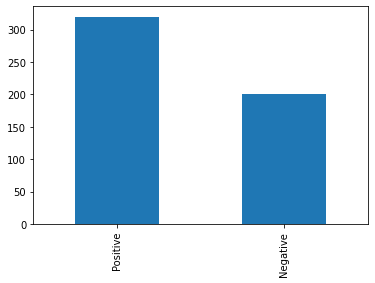

In [91]:
diabetes_df['class'].value_counts().plot.bar()

- Imbalanced Dataset.

- Given the size of the entire dataset: 
    - Negative class - 38.4%
    - Positive class - 61.6%

<AxesSubplot:>

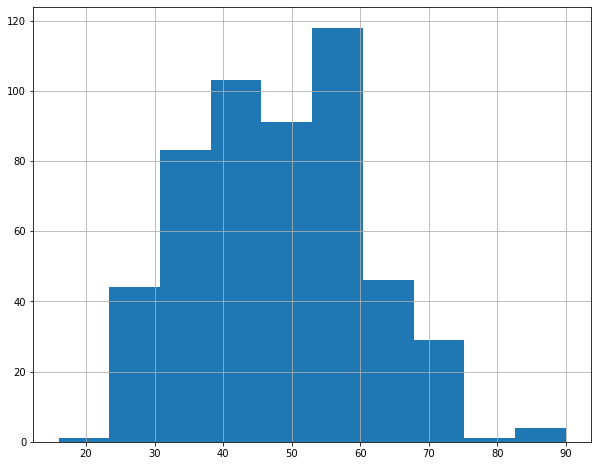

In [92]:
diabetes_df['Age'].hist(bins = 10, figsize = (10,8))

#### Observation: 

- Age follows gaussian distribution; it can be a usefull feature for linear models

In [93]:
train, test= train_test_split(diabetes_df, test_size = 0.2, random_state = 0, stratify = diabetes_df['class'])

#### Checking Distribution of Data in Train and Test Set 

Since it is an imbalanced data , we can try to split the data in train and test such that , both classes are proportionally equal 

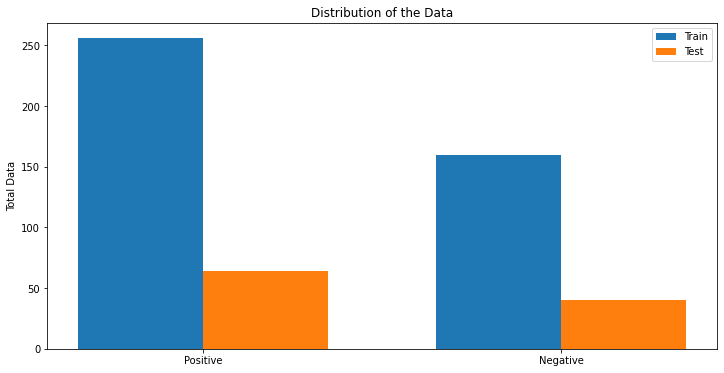

In [94]:
width = 0.35  # the width of the bars
x = np.arange(2)
fig, ax = plt.subplots(figsize=(12,6))
rects1 = ax.bar(x - width/2, train['class'].value_counts(), width, label='Train')
rects2 = ax.bar(x + width/2, test['class'].value_counts(), width, label='Test')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Total Data')
ax.set_title('Distribution of the Data')
ax.set_xticks(x)
ax.set_xticklabels(['Positive', 'Negative'])
ax.legend()
plt.show()

### EDA on Train Data

#### Age vs Class

<AxesSubplot:>

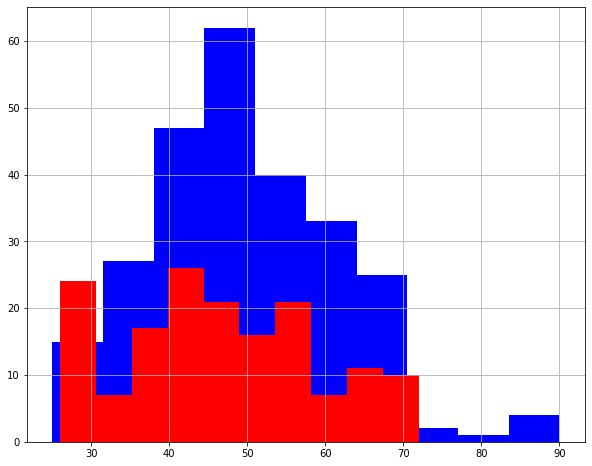

In [95]:
train[train['class'] == 'Positive']['Age'].hist(bins = 10, figsize = (10,8), color = 'b')
train[train['class'] == 'Negative']['Age'].hist(bins = 10, figsize = (10,8), color = 'r')

<AxesSubplot:title={'center':'Age'}, xlabel='class'>

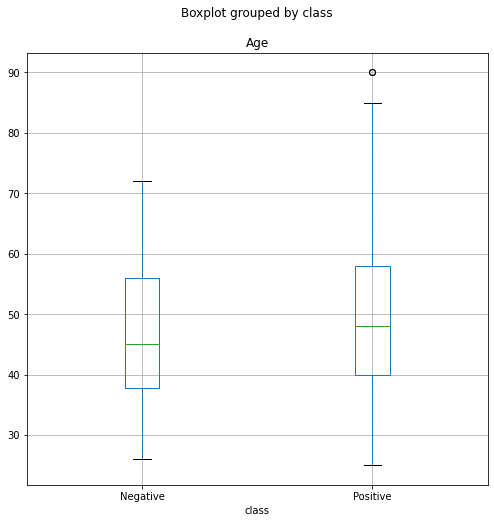

In [97]:
#https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.boxplot.html

train.boxplot(column="Age", by= "class", figsize= (8,8)) 

#### Observations: 

- Only 1 outlier is in the positive class, can ignore that datapoint.
- Through histogram we can see that, Age cannot be the only factor to classify the diabetes patient. 
- Since the graphs are overlapping, rather seperate, we can try to combine this feature with others when trying to model our data.

#### Gender vs Class

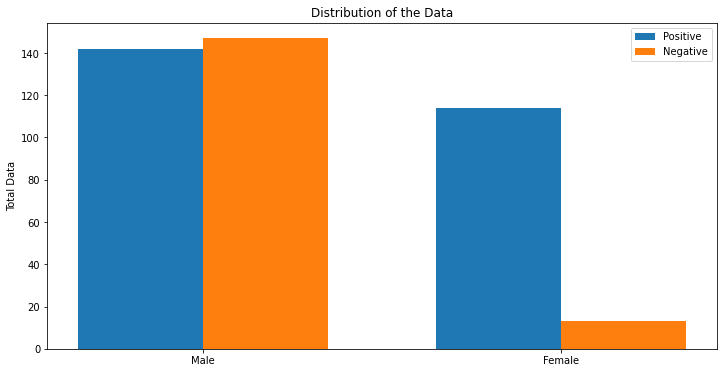

In [98]:
width = 0.35  # the width of the bars
x = np.arange(2)
fig, ax = plt.subplots(figsize=(12,6))
rects1 = ax.bar(x - width/2, train[train['class'] == 'Positive']['Gender'].value_counts(), width, label='Positive')
rects2 = ax.bar(x + width/2, train[train['class'] == 'Negative']['Gender'].value_counts(), width, label='Negative')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Total Data')
ax.set_title('Distribution of the Data')
ax.set_xticks(x)
ax.set_xticklabels(['Male', 'Female'])
ax.legend()
plt.show()

In [99]:
#Given the stats, females have a high chance of getting diagnosed with diabetes' 
train.groupby(['Gender', 'class']).size()

Gender  class   
Female  Negative     13
        Positive    142
Male    Negative    147
        Positive    114
dtype: int64

#### Observations

- 91% females are diagnosied with positive diabetes.. ( we can get 91 % accuracy if gender is female, and taken only gender as feature)
- 43% males are diagnosed with positive diabetes

### Polyuria vs Class

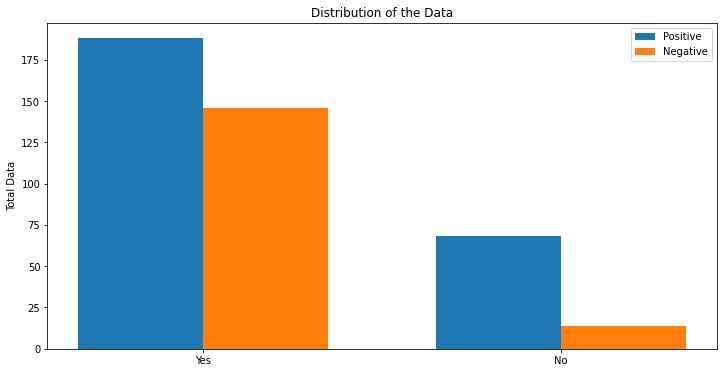

In [101]:
width = 0.35  # the width of the bars
x = np.arange(2)
fig, ax = plt.subplots(figsize=(12,6))
rects1 = ax.bar(x - width/2, train[train['class'] == 'Positive']['Polyuria'].value_counts(), width, label='Positive')
rects2 = ax.bar(x + width/2, train[train['class'] == 'Negative']['Polyuria'].value_counts(), width, label='Negative')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Total Data')
ax.set_title('Distribution of the Data')
ax.set_xticks(x)
ax.set_xticklabels(['Yes', 'No'])
ax.legend()
plt.show()

In [102]:
train.groupby(['Polyuria', 'class']).size()

Polyuria  class   
No        Negative    146
          Positive     68
Yes       Negative     14
          Positive    188
dtype: int64

### Polydipsia vs Class

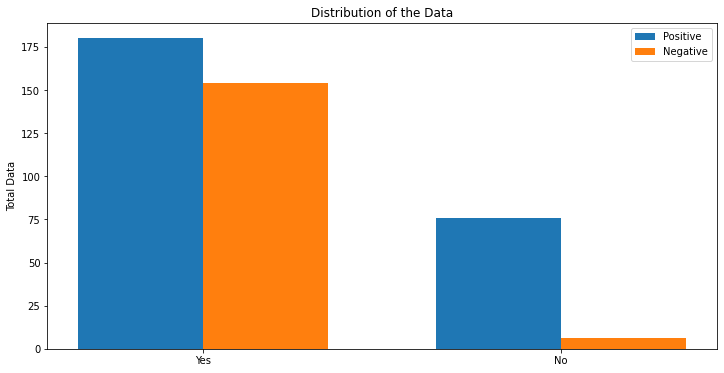

In [103]:
width = 0.35  # the width of the bars
x = np.arange(2)
fig, ax = plt.subplots(figsize=(12,6))
rects1 = ax.bar(x - width/2, train[train['class'] == 'Positive']['Polydipsia'].value_counts(), width, label='Positive')
rects2 = ax.bar(x + width/2, train[train['class'] == 'Negative']['Polydipsia'].value_counts(), width, label='Negative')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Total Data')
ax.set_title('Distribution of the Data')
ax.set_xticks(x)
ax.set_xticklabels(['Yes', 'No'])
ax.legend()
plt.show()

In [104]:
train.groupby(['Polydipsia', 'class']).size()

Polydipsia  class   
No          Negative    154
            Positive     76
Yes         Negative      6
            Positive    180
dtype: int64

### Sudden weight loss vs Class

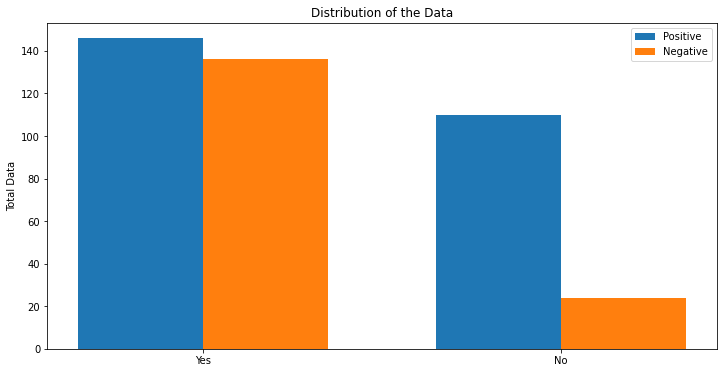

In [105]:
width = 0.35  # the width of the bars
x = np.arange(2)
fig, ax = plt.subplots(figsize=(12,6))
rects1 = ax.bar(x - width/2, train[train['class'] == 'Positive']['sudden weight loss'].value_counts(), width, label='Positive')
rects2 = ax.bar(x + width/2, train[train['class'] == 'Negative']['sudden weight loss'].value_counts(), width, label='Negative')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Total Data')
ax.set_title('Distribution of the Data')
ax.set_xticks(x)
ax.set_xticklabels(['Yes', 'No'])
ax.legend()
plt.show()

In [106]:
train.groupby(['sudden weight loss', 'class']).size()

sudden weight loss  class   
No                  Negative    136
                    Positive    110
Yes                 Negative     24
                    Positive    146
dtype: int64

## Get Train and Test Data

In [107]:
train_x, train_y = train.drop('class', axis = 1), train['class']
test_x, test_y = test.drop('class', axis = 1), test['class']

In [108]:
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.base import BaseEstimator, TransformerMixin


#Dataframeselector to select rows of particular column

class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    
    def fit(self, X , y = None):
        return self
    
    def transform(self, X):
        return X[self.attribute_names].values

In [109]:
numerical_columns= ['Age']
categorical_columns = list(train_x.columns)
categorical_columns.remove('Age')

In [110]:
numeric_pipeline = Pipeline([
                            ('selector', DataFrameSelector(numerical_columns)), #select feature
                            ('std_scalar', StandardScaler()) #apply std scalar
                            ])

categorical_pipeline = Pipeline([
                        ('selector', DataFrameSelector(categorical_columns)), #select feature
                        ('ohe_encoder', OneHotEncoder(sparse = False)) #apply onehot encoding
                        ])


In [111]:
# Combine both pipelines
preprocess_pipeline = FeatureUnion(transformer_list=[('num_pipeline', numeric_pipeline),
                                                    ('cat_pipeline', categorical_pipeline)])

In [112]:
X_train_preprocessed = preprocess_pipeline.fit_transform(train_x)  #fit and transform train data
X_test_preprocessed = preprocess_pipeline.transform(test_x) #transform test data

In [113]:
lbl_encoder = LabelEncoder().fit(train_y)

y_train = lbl_encoder.transform(train_y) #label encode output feature
y_test = lbl_encoder.transform(test_y)

In [114]:
#Utility Function to display confusion matrix, accuracy, precision score, recall score, f1_score for both train and test data

def model_eval(y_train_true, y_train_pred, y_test_true, y_test_pred):
    
    #computing confusion matrix
    cf_train = confusion_matrix(y_train_true, y_train_pred)
    ca_train = accuracy_score(y_train_true, y_train_pred)
    ps_train = precision_score(y_train_true, y_train_pred)
    rs_train = recall_score(y_train_true, y_train_pred)
    f1_train = f1_score(y_train_true, y_train_pred)
    print(">>>>>>>>>>Training Performance<<<<<<<<<<")
    print("Average Train Confusion Matrix:\n", cf_train)
    print("Average Train Accuracy: {0:0.2%}".format(ca_train))
    print("Average Train Precision {0:0.2%}".format(ps_train))
    print("Average Train Recall: {0:0.2%}".format(rs_train))
    print("Average Train F1: {0:0.2%}".format(f1_train))

    cf_test = confusion_matrix(y_test_true, y_test_pred)
    ca_test = accuracy_score(y_test_true, y_test_pred)
    ps_test = precision_score(y_test_true, y_test_pred)
    rs_test = recall_score(y_test_true, y_test_pred)
    f1_test = f1_score(y_test_true, y_test_pred)
    print("\n>>>>>>>>>>Testing Performance<<<<<<<<<<")
    print("Average Test Confusion Matrix:\n", cf_test)
    print("Average Test Accuracy: {0:0.2%}".format(ca_test))
    print("Average Test Precision {0:0.2%}".format(ps_test))
    print("Average Test Recall {0:0.2%}".format(rs_test))
    print("Average Test F1: {0:0.2%}".format(f1_test))

### Linear Model : logistic Regression

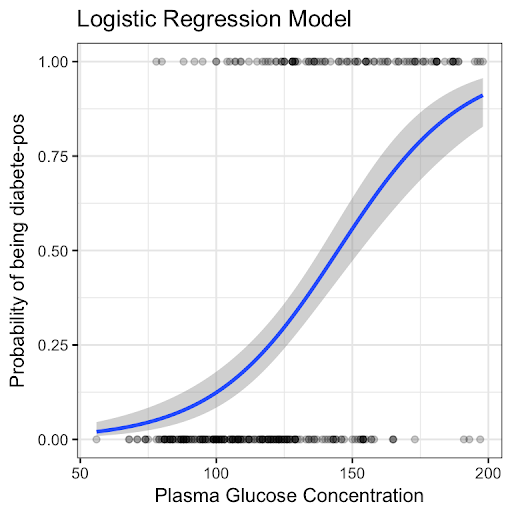

ref: https://www.google.com/url?sa=i&url=http%3A%2F%2Fwww.sthda.com%2Fenglish%2Farticles%2F36-classification-methods-essentials%2F151-logistic-regression-essentials-in-r%2F&psig=AOvVaw1eC-RJGOQW81wJOXlQm-uo&ust=1606561809082000&source=images&cd=vfe&ved=0CA0QjhxqFwoTCKikq6LLou0CFQAAAAAdAAAAABAc

In [115]:
softmax_reg = SGDClassifier(loss='log')
softmax_reg.fit(X_train_preprocessed, y_train.ravel())

#predict output classes for both train and test data
y_train_pred = softmax_reg.predict(X_train_preprocessed)
y_test_pred = softmax_reg.predict(X_test_preprocessed)

model_eval(y_train, y_train_pred, y_test, y_test_pred)

>>>>>>>>>>Training Performance<<<<<<<<<<
Average Train Confusion Matrix:
 [[110  50]
 [  4 252]]
Average Train Accuracy: 87.02%
Average Train Precision 83.44%
Average Train Recall: 98.44%
Average Train F1: 90.32%

>>>>>>>>>>Testing Performance<<<<<<<<<<
Average Test Confusion Matrix:
 [[28 12]
 [ 3 61]]
Average Test Accuracy: 85.58%
Average Test Precision 83.56%
Average Test Recall 95.31%
Average Test F1: 89.05%


### Decision Tree Classifier

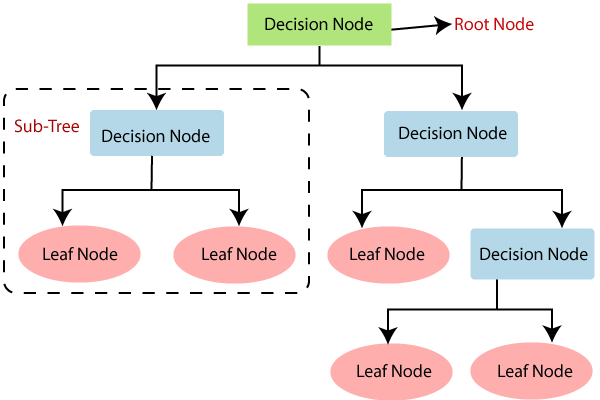

ref:https://www.google.com/url?sa=i&url=https%3A%2F%2Fwww.javatpoint.com%2Fmachine-learning-decision-tree-classification-algorithm&psig=AOvVaw3cBsOxkm6PtC3OmIkqjeCG&ust=1606561772417000&source=images&cd=vfe&ved=0CA0QjhxqFwoTCKC_yJHLou0CFQAAAAAdAAAAABAD

In [116]:
dt_clf = DecisionTreeClassifier(random_state=0)

dt_clf.fit(X_train_preprocessed, y_train.ravel())

#predict output classes for both train and test data
y_train_pred = dt_clf.predict(X_train_preprocessed)
y_test_pred = dt_clf.predict(X_test_preprocessed)

model_eval(y_train, y_train_pred, y_test, y_test_pred)

>>>>>>>>>>Training Performance<<<<<<<<<<
Average Train Confusion Matrix:
 [[160   0]
 [  0 256]]
Average Train Accuracy: 100.00%
Average Train Precision 100.00%
Average Train Recall: 100.00%
Average Train F1: 100.00%

>>>>>>>>>>Testing Performance<<<<<<<<<<
Average Test Confusion Matrix:
 [[36  4]
 [ 0 64]]
Average Test Accuracy: 96.15%
Average Test Precision 94.12%
Average Test Recall 100.00%
Average Test F1: 96.97%


### Random Forest Classifier

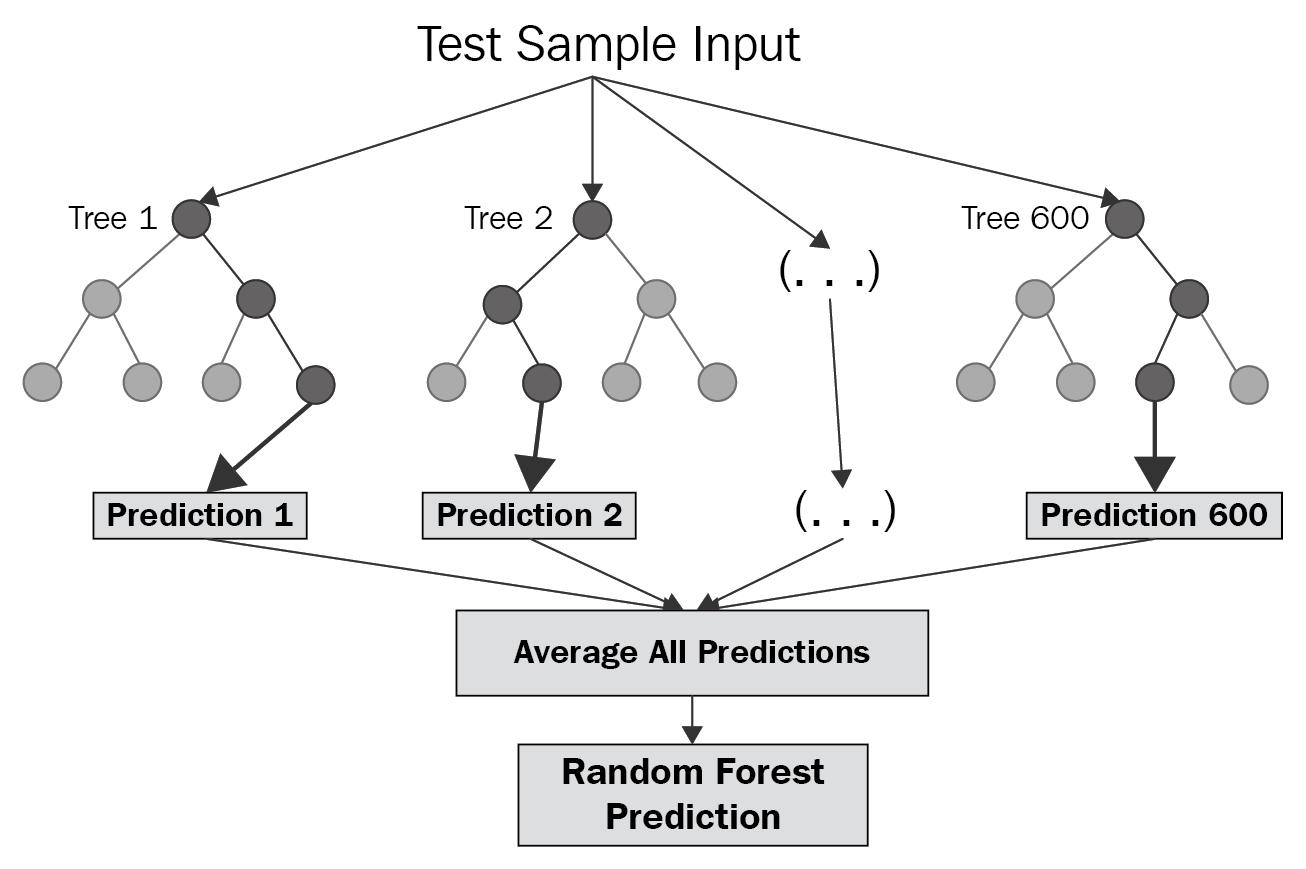

ref: https://www.google.com/url?sa=i&url=https%3A%2F%2Fmedium.com%2Fswlh%2Frandom-forest-and-its-implementation-71824ced454f&psig=AOvVaw1QSz7hLHUSJI-_qD67dQuq&ust=1606561705336000&source=images&cd=vfe&ved=0CA0QjhxqFwoTCMCIjPfKou0CFQAAAAAdAAAAABAD

In [117]:
rf_clf = RandomForestClassifier(max_depth=2, random_state=0)

rf_clf.fit(X_train_preprocessed, y_train.ravel())

#predict output classes for both train and test data
y_train_pred = rf_clf.predict(X_train_preprocessed)
y_test_pred = rf_clf.predict(X_test_preprocessed)

model_eval(y_train, y_train_pred, y_test, y_test_pred)

>>>>>>>>>>Training Performance<<<<<<<<<<
Average Train Confusion Matrix:
 [[136  24]
 [ 18 238]]
Average Train Accuracy: 89.90%
Average Train Precision 90.84%
Average Train Recall: 92.97%
Average Train F1: 91.89%

>>>>>>>>>>Testing Performance<<<<<<<<<<
Average Test Confusion Matrix:
 [[37  3]
 [ 5 59]]
Average Test Accuracy: 92.31%
Average Test Precision 95.16%
Average Test Recall 92.19%
Average Test F1: 93.65%


#### Hyperparameter Tune Random Forest Classifier

In [118]:
params = {'n_estimators': [10,50,100,150],
         'max_depth' :[2,3,4,5, 6,7,8],
         'min_samples_split': [2,4,6,8]}

rf_base = RandomForestClassifier(random_state=0)

gridsearch_clf = GridSearchCV(rf_base, param_grid=params, refit = True)
gridsearch_clf.fit(X_train_preprocessed, y_train)

GridSearchCV(estimator=RandomForestClassifier(random_state=0),
             param_grid={'max_depth': [2, 3, 4, 5, 6, 7, 8],
                         'min_samples_split': [2, 4, 6, 8],
                         'n_estimators': [10, 50, 100, 150]})

In [119]:
gridsearch_clf.best_params_

{'max_depth': 6, 'min_samples_split': 2, 'n_estimators': 50}

In [120]:
gridsearch_clf.best_score_

0.9736374067699369

In [121]:
#predict output classes for both train and test data
y_train_pred = gridsearch_clf.predict(X_train_preprocessed)
y_test_pred = gridsearch_clf.predict(X_test_preprocessed)

model_eval(y_train, y_train_pred, y_test, y_test_pred)

>>>>>>>>>>Training Performance<<<<<<<<<<
Average Train Confusion Matrix:
 [[159   1]
 [  4 252]]
Average Train Accuracy: 98.80%
Average Train Precision 99.60%
Average Train Recall: 98.44%
Average Train F1: 99.02%

>>>>>>>>>>Testing Performance<<<<<<<<<<
Average Test Confusion Matrix:
 [[36  4]
 [ 4 60]]
Average Test Accuracy: 92.31%
Average Test Precision 93.75%
Average Test Recall 93.75%
Average Test F1: 93.75%


### shallow neural networks  -> 1 hidden layer

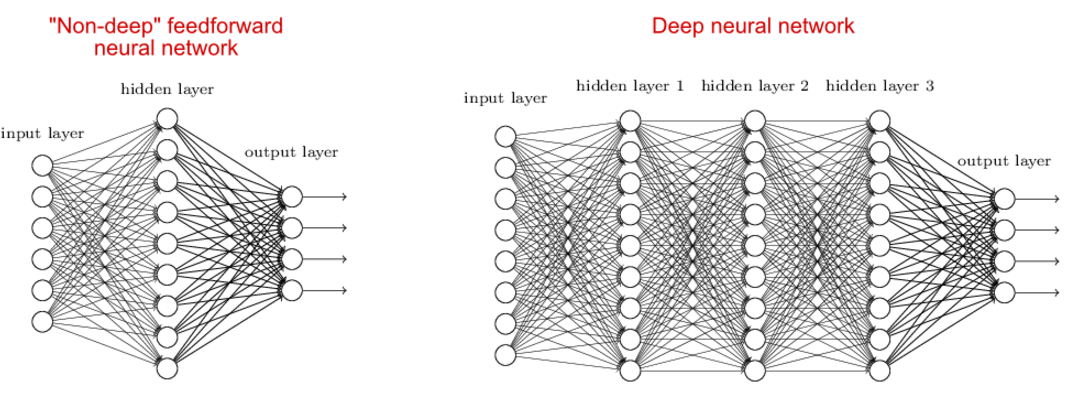

ref: https://www.quora.com/What-is-the-difference-between-deep-and-shallow-neural-networks

In [122]:
from keras.optimizers import Adam
from keras.losses import mse
from keras.models import Sequential
from keras.layers import Dropout, Dense
from keras.layers.normalization import BatchNormalization

__Here we experiment with different number of neurons and dropout probability , but overall structure remained same__

In [123]:
shallow_model = Sequential()
shallow_model.add(Dense(64, activation='relu',input_shape=(X_train_preprocessed.shape[1],), kernel_initializer = keras.initializers.glorot_uniform(seed = 0)))
shallow_model.add(Dropout(0.25))
shallow_model.add(Dense(1, activation = 'sigmoid'))

opt = keras.optimizers.Adam(learning_rate=0.01)
shallow_model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

history = shallow_model.fit(X_train_preprocessed, y_train, epochs=10, validation_split=0.1, verbose = 1)

Epoch 1/10
12/12 [==============================] - 0s 9ms/step - loss: 0.4847 - accuracy: 0.7460 - val_loss: 0.2824 - val_accuracy: 0.8095
Epoch 2/10
12/12 [==============================] - 0s 2ms/step - loss: 0.2232 - accuracy: 0.9225 - val_loss: 0.1940 - val_accuracy: 0.8571
Epoch 3/10
12/12 [==============================] - 0s 2ms/step - loss: 0.1864 - accuracy: 0.9225 - val_loss: 0.1838 - val_accuracy: 0.9048
Epoch 4/10
12/12 [==============================] - 0s 4ms/step - loss: 0.1693 - accuracy: 0.9332 - val_loss: 0.1593 - val_accuracy: 0.9048
Epoch 5/10
12/12 [==============================] - 0s 2ms/step - loss: 0.1618 - accuracy: 0.9412 - val_loss: 0.1321 - val_accuracy: 0.9048
Epoch 6/10
12/12 [==============================] - 0s 2ms/step - loss: 0.1424 - accuracy: 0.9519 - val_loss: 0.0893 - val_accuracy: 1.0000
Epoch 7/10
12/12 [==============================] - 0s 2ms/step - loss: 0.1133 - accuracy: 0.9679 - val_loss: 0.0904 - val_accuracy: 0.9762
Epoch 8/10
12/12 [==

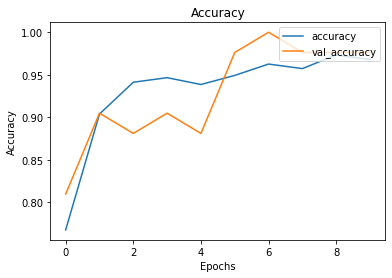

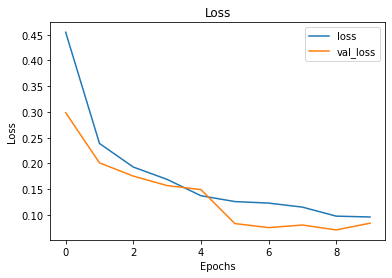

In [72]:
#Plot accuracy and loss graph

accuracy_fig = plt.figure()
accuracy_ax = accuracy_fig.add_subplot(111)
accuracy_ax.plot(history.history['accuracy'])
accuracy_ax.plot(history.history['val_accuracy'])
accuracy_ax.set_title('Accuracy')
accuracy_ax.set_xlabel('Epochs')
accuracy_ax.set_ylabel('Accuracy')
accuracy_ax.legend(['accuracy', 'val_accuracy'], loc='upper right')

loss_fig = plt.figure()
loss_ax = loss_fig.add_subplot(111)
loss_ax.plot(history.history['loss'])
loss_ax.plot(history.history['val_loss'])
loss_ax.set_title('Loss')
loss_ax.set_xlabel('Epochs')
loss_ax.set_ylabel('Loss')
loss_ax.legend(['loss', 'val_loss'], loc='upper right')


plt.show()

In [124]:
#Predict output classes for both train and test data
y_train_pred = (shallow_model.predict(X_train_preprocessed) > 0.5).astype("int32")
y_test_pred = (shallow_model.predict(X_test_preprocessed) > 0.5).astype("int32")

model_eval(y_train, y_train_pred, y_test, y_test_pred)

>>>>>>>>>>Training Performance<<<<<<<<<<
Average Train Confusion Matrix:
 [[158   2]
 [  8 248]]
Average Train Accuracy: 97.60%
Average Train Precision 99.20%
Average Train Recall: 96.88%
Average Train F1: 98.02%

>>>>>>>>>>Testing Performance<<<<<<<<<<
Average Test Confusion Matrix:
 [[40  0]
 [ 5 59]]
Average Test Accuracy: 95.19%
Average Test Precision 100.00%
Average Test Recall 92.19%
Average Test F1: 95.93%


### Deep Neural Network

-  We can add few more hidden layers for this DNN , but given the size of data , its kinda overkill, so we stick with 2 hidden layers 
- Experiment with range of values until the accuracy comes out to be perfect

In [125]:
dnn_model = Sequential()
dnn_model.add(Dense(64, activation='relu',input_shape=(X_train_preprocessed.shape[1],), kernel_initializer = keras.initializers.glorot_uniform(seed = 0)))
dnn_model.add(Dropout(0.2))
dnn_model.add(Dense(64,activation ='relu'))
dnn_model.add(Dropout(0.2))
dnn_model.add(Dense(1, activation = 'sigmoid'))

opt = keras.optimizers.Adam(learning_rate=0.01)
dnn_model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

history = dnn_model.fit(X_train_preprocessed, y_train, epochs=20, validation_split=0.1, verbose = 1)

Epoch 1/20
12/12 [==============================] - 0s 9ms/step - loss: 0.4461 - accuracy: 0.7701 - val_loss: 0.2098 - val_accuracy: 0.8571
Epoch 2/20
12/12 [==============================] - 0s 2ms/step - loss: 0.1885 - accuracy: 0.9385 - val_loss: 0.1113 - val_accuracy: 0.9762
Epoch 3/20
12/12 [==============================] - 0s 2ms/step - loss: 0.1688 - accuracy: 0.9305 - val_loss: 0.1043 - val_accuracy: 0.9762
Epoch 4/20
12/12 [==============================] - 0s 2ms/step - loss: 0.1632 - accuracy: 0.9412 - val_loss: 0.0858 - val_accuracy: 0.9762
Epoch 5/20
12/12 [==============================] - 0s 2ms/step - loss: 0.1266 - accuracy: 0.9465 - val_loss: 0.0540 - val_accuracy: 1.0000
Epoch 6/20
12/12 [==============================] - 0s 2ms/step - loss: 0.0803 - accuracy: 0.9786 - val_loss: 0.0902 - val_accuracy: 0.9524
Epoch 7/20
12/12 [==============================] - 0s 2ms/step - loss: 0.0584 - accuracy: 0.9813 - val_loss: 0.0410 - val_accuracy: 0.9762
Epoch 8/20
12/12 [==

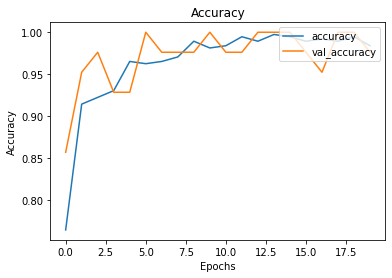

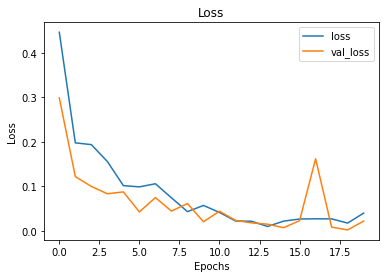

In [76]:
#Plot accuracy and graph

accuracy_fig = plt.figure()
accuracy_ax = accuracy_fig.add_subplot(111)
accuracy_ax.plot(history.history['accuracy'])
accuracy_ax.plot(history.history['val_accuracy'])
accuracy_ax.set_title('Accuracy')
accuracy_ax.set_xlabel('Epochs')
accuracy_ax.set_ylabel('Accuracy')
accuracy_ax.legend(['accuracy', 'val_accuracy'], loc='upper right')

loss_fig = plt.figure()
loss_ax = loss_fig.add_subplot(111)
loss_ax.plot(history.history['loss'])
loss_ax.plot(history.history['val_loss'])
loss_ax.set_title('Loss')
loss_ax.set_xlabel('Epochs')
loss_ax.set_ylabel('Loss')
loss_ax.legend(['loss', 'val_loss'], loc='upper right')


plt.show()

In [126]:
#Predict output classes for both train and test data
y_train_pred = (dnn_model.predict(X_train_preprocessed) > 0.5).astype("int32")
y_test_pred = (dnn_model.predict(X_test_preprocessed) > 0.5).astype("int32")

model_eval(y_train, y_train_pred, y_test, y_test_pred)

>>>>>>>>>>Training Performance<<<<<<<<<<
Average Train Confusion Matrix:
 [[160   0]
 [  0 256]]
Average Train Accuracy: 100.00%
Average Train Precision 100.00%
Average Train Recall: 100.00%
Average Train F1: 100.00%

>>>>>>>>>>Testing Performance<<<<<<<<<<
Average Test Confusion Matrix:
 [[36  4]
 [ 1 63]]
Average Test Accuracy: 95.19%
Average Test Precision 94.03%
Average Test Recall 98.44%
Average Test F1: 96.18%


## Comparing Performances


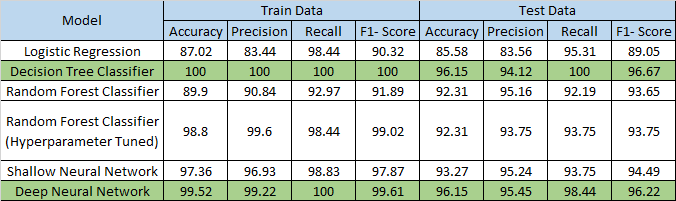

#### Observations 

- Deep Neural Network performed well in terms of overall accuracy ( precision, recall and F1- score) without overfitting the data
- Decision Tree Classifier came really close to the DNN, and performed even better on Training Data